In [60]:
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point 

from random import *

%qtconsole

In [61]:
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\processed\\'
docs_img_dir = 'C:\\Users\\bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\docs\\img\\'

In [62]:
df_train_val = pd.read_csv(data_raw_dir + 'training_values.csv')
df_test_val = pd.read_csv(data_raw_dir + 'test_values.csv')
df_train_lab = pd.read_csv(data_raw_dir + 'training_labels.csv')

print(df_train_val.shape)
print(df_test_val.shape)

df_comp_val = pd.read_csv(data_interim_dir+'comp_val_gps_corrected.csv',index_col=0)

print(df_comp_val.shape)
print(df_comp_val.columns)

df_comp_val.head(2)

(59400, 40)
(14850, 40)
(74250, 41)
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')


C:\Users\bryan\Anaconda3\envs\geo_code\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [63]:
label_list = ['amount_tsh - Total static head (amount water available to waterpoint)',
'date_recorded - The date the row was entered',
'funder - Who funded the well',
'gps_height - Altitude of the well',
'installer - Organization that installed the well',
'longitude - GPS coordinate',
'latitude - GPS coordinate',
'wpt_name - Name of the waterpoint if there is one',
'num_private - ',
'basin - Geographic water basin',
'subvillage - Geographic location',
'region - Geographic location',
'region_code - Geographic location (coded)',
'district_code - Geographic location (coded)',
'lga - Geographic location',
'ward - Geographic location',
'population - Population around the well',
'public_meeting - True/False',
'recorded_by - Group entering this row of data',
'scheme_management - Who operates the waterpoint',
'scheme_name - Who operates the waterpoint',
'permit - If the waterpoint is permitted',
'construction_year - Year the waterpoint was constructed',
'extraction_type - The kind of extraction the waterpoint uses',
'extraction_type_group - The kind of extraction the waterpoint uses',
'extraction_type_class - The kind of extraction the waterpoint uses',
'management - How the waterpoint is managed',
'management_group - How the waterpoint is managed',
'payment - What the water costs',
'payment_type - What the water costs',
'water_quality - The quality of the water',
'quality_group - The quality of the water',
'quantity - The quantity of water',
'quantity_group - The quantity of water',
'source - The source of the water',
'source_type - The source of the water',
'source_class - The source of the water',
'waterpoint_type - The kind of waterpoint',
'waterpoint_type_group - The kind of waterpoint']

label_list = [x.split(' - ') for x in label_list]
label_desc = [y for (x,y) in label_list]
label_list = [x for (x,y) in label_list]

label_dict = {}
label_dict = dict(zip(label_list,label_desc))

In [64]:
var = 'id'
def explore_data(var,slice=-len(df_comp_val[var].unique())):
    print(label_dict[var])
    print(df_comp_val[var].dtype)
    print(df_comp_val[var].unique()[slice:])
    print(str(len(df_comp_val[var].unique())) + ' unique values')
    print(str(df_comp_val[var].isna().sum())+' missing or null values')

### Missing Data

In [66]:
df_comp_val = df_comp_val[['id',
 'amount_tsh',
 'gps_height',
 'date_recorded',
 'construction_year',
 'installer',
 'longitude',
 'latitude',
 'basin',
 'region',
 'district_code',
 'population',
 'public_meeting',
 'permit',
 'extraction_type_class',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 ]]

df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 74249
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   gps_height             74250 non-null  int64  
 3   date_recorded          74250 non-null  object 
 4   construction_year      74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   basin                  74250 non-null  object 
 9   region                 74250 non-null  object 
 10  district_code          74250 non-null  int64  
 11  population             74250 non-null  int64  
 12  public_meeting         70095 non-null  object 
 13  permit                 70457 non-null  object 
 14  extraction_type_class  74250 non-null  object 
 15  ma

#### id

In [67]:
var='id'

print(df_comp_val[var].unique())

# type int - index / id value - Good

df_comp_val[var].value_counts(sort=True)[:2]

# no duplicates - no error values

[69572  8776 34310 ... 28749 33492 68707]


0        1
36219    1
Name: id, dtype: int64

#### amount_tsh

In [68]:
var = 'amount_tsh'
explore_data(var,-5)

# type float - some decimal values it looks like - Good

df_comp_val[var].value_counts(sort=True)[:3]

Total static head (amount water available to waterpoint)
float64
[5.90e+01 3.50e+04 3.00e+00 2.55e+03 5.00e-01]
102 unique values
0 missing or null values


0.0         52049
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
70000.0         2
53.0            1
250000.0        1
900.0           1
3.0             1
Name: amount_tsh, Length: 84, dtype: int64

In [69]:
# 70% of data read zero, could be an bad column but will keep for now.

#### date_recorded

In [70]:
var = 'date_recorded'
df_comp_val[var] = pd.to_datetime(df_comp_val[var],format='%Y-%m-%d')

explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)

The date the row was entered
datetime64[ns]
['2004-01-12T00:00:00.000000000' '2011-09-07T00:00:00.000000000'
 '2004-12-03T00:00:00.000000000' '2011-09-22T00:00:00.000000000'
 '2004-01-09T00:00:00.000000000']
369 unique values
0 missing or null values


2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
             ... 
2011-09-11      1
2004-01-09      1
2011-09-22      1
2004-02-23      1
2011-09-10      1
Name: date_recorded, Length: 369, dtype: int64

#### year_recorded

In [71]:
var = 'year_recorded'

df_comp_val[var] = df_comp_val['date_recorded'].dt.year
df_comp_val[var].value_counts(sort=True)

2011    35908
2013    30210
2012     8089
2004       41
2001        1
2002        1
Name: year_recorded, dtype: int64

#### longitude

In [72]:
var = 'longitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[38.85266884 37.45163346 34.7398045  35.43273168 34.76505448]
71938 unique values
0 missing or null values


34.211478    135
34.149346    100
34.167443     94
32.278174     86
33.995811     85
            ... 
36.681688      1
33.319196      1
38.348075      1
37.806786      1
35.164770      1
Name: longitude, Length: 71938, dtype: int64

#### latitude

In [73]:
var = 'latitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[ -6.58284095  -5.35042799  -4.58558667 -10.58415869 -11.22601197]
71937 unique values
0 missing or null values


-2.863661     135
-2.754004     100
-2.656559      94
-2.877503      86
-2.748329      85
             ... 
-4.790095       1
-3.669355       1
-3.167823       1
-1.844915       1
-10.772897      1
Name: latitude, Length: 71937, dtype: int64

#### installer

In [74]:
var = 'installer'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

Organization that installed the well
object
['Mombia' 'CANACO' 'Banane' 'MAJIJA CHARLES' 'Central government/TLC']
2411 unique values
4532 missing or null values


DWE                         21751
Government                   2282
RWE                          1498
Commu                        1347
DANIDA                       1305
                            ...  
Domnik                          1
CHELA                           1
Childreach international        1
Lion's club                     1
communit                        1
Name: installer, Length: 2410, dtype: int64

In [75]:
df_comp_val[var].fillna('unknown',inplace=True)

#### basin

In [76]:
var = 'basin'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True,normalize=True)

Geographic water basin
object
['Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
9 unique values
0 missing or null values


Lake Victoria              0.173347
Pangani                    0.150074
Rufiji                     0.134505
Internal                   0.129859
Lake Tanganyika            0.108444
Wami / Ruvu                0.102047
Lake Nyasa                 0.085279
Ruvuma / Southern Coast    0.075246
Lake Rukwa                 0.041199
Name: basin, dtype: float64

#### region

In [77]:
var = 'region'
explore_data(var,-5)

Geographic location
object
['Geita' 'Morogoro' 'Songwe' 'Dar es Salaam' 'Katavi']
26 unique values
0 missing or null values


#### district_code

In [78]:
var = 'district_code'
explore_data(var,-5)

print(df_comp_val[var].value_counts(sort=True))

for rc in df_comp_val[var].unique():
    print(df_comp_val[['region',var]][df_comp_val[var] == rc].drop_duplicates())


Geographic location (coded)
int64
[30 13  0 80 67]
20 unique values
0 missing or null values
1     15299
2     13929
3     12521
4     11253
5      5428
6      5108
7      4166
8      1282
30     1256
33     1063
53      921
43      653
13      496
23      360
63      264
62      127
60       76
0        27
80       13
67        8
Name: district_code, dtype: int64
            region  district_code
0           Njombe              5
11          Ruvuma              5
79           Geita              5
85          Mwanza              5
89          Dodoma              5
104    Kilimanjaro              5
119        Manyara              5
142         Tabora              5
213         Songwe              5
290       Morogoro              5
320         Mtwara              5
361          Tanga              5
465         Arusha              5
10013        Mbeya              5
26974    Shinyanga              5
             region  district_code
1              Mara              2
12           Simiyu

#### population

In [79]:
var = 'population'
explore_data(var,-5)

print(df_comp_val[var].value_counts().sort_index()[:3])

Population around the well
int64
[2554 7600 1869 1542 2960]
1128 unique values
0 missing or null values
0    26834
1     8782
2        9
Name: population, dtype: int64


#### public_meeting

In [80]:
var = 'public_meeting'
explore_data(var,-5)

prob = df_comp_val[var].value_counts(normalize=True)

True/False
object
[True nan False]
3 unique values
4155 missing or null values


In [81]:
for idx in df_comp_val[var].isna().index.tolist():
    df_comp_val.loc[idx,var] = np.random.choice([prob.index[0],prob.index[1]],p=[prob.values[0],prob.values[1]])

In [82]:
df_comp_val[var] = df_comp_val[var].astype(int)

df_comp_val[var].value_counts(normalize=True)

1    0.907609
0    0.092391
Name: public_meeting, dtype: float64

#### permit

In [83]:
var = 'permit'
explore_data(var,-5)

prob = df_comp_val[var].value_counts(normalize=True)
prob

If the waterpoint is permitted
object
[False True nan]
3 unique values
3793 missing or null values


True     0.689868
False    0.310132
Name: permit, dtype: float64

In [84]:
for idx in df_comp_val[var].isna().index.tolist():
    df_comp_val.loc[idx,var] = np.random.choice([prob.index[0],prob.index[1]],p=[prob.values[0],prob.values[1]])

In [85]:
df_comp_val[var] = df_comp_val[var].astype(int)

df_comp_val[var].value_counts(normalize=True)

1    0.690882
0    0.309118
Name: permit, dtype: float64

#### construction_year

Year the waterpoint was constructed
int64
[1969 1981 1964 1966 1965]
55 unique values
0 missing or null values
0       25969
2010     3314
2008     3243
Name: construction_year, dtype: int64


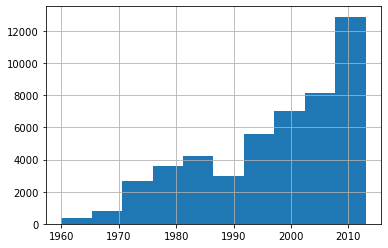

In [86]:
var = 'construction_year'
explore_data(var,-5)


print(df_comp_val[var].value_counts()[:3])

# nearly 1/3 of values are zero (N/A)

df_comp_val[df_comp_val[var]!=0].construction_year.hist();

In [87]:
df_comp_val[var] = df_comp_val[var].replace(0,df_comp_val[var].median())

In [88]:
df_comp_val[var].value_counts()

1986.0    26522
2010.0     3314
2008.0     3243
2009.0     3196
2000.0     2578
2007.0     1960
2006.0     1892
2011.0     1591
2003.0     1579
2004.0     1417
2012.0     1347
2002.0     1343
1995.0     1283
2005.0     1275
1978.0     1267
1999.0     1222
1998.0     1190
1985.0     1177
1990.0     1176
1996.0     1020
1980.0     1005
1984.0      970
1994.0      940
1982.0      926
1972.0      892
1997.0      821
1974.0      814
1992.0      807
1993.0      745
2001.0      680
1988.0      657
1983.0      594
1975.0      561
1976.0      525
1970.0      493
1991.0      407
1989.0      396
1987.0      370
1981.0      291
1977.0      247
1979.0      245
1973.0      227
2013.0      209
1971.0      177
1960.0      124
1963.0      107
1967.0      106
1968.0       93
1969.0       77
1964.0       48
1962.0       36
1961.0       28
1965.0       21
1966.0       19
Name: construction_year, dtype: int64

#### extraction_type_class

In [89]:
var = 'extraction_type_class'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
7 unique values
0 missing or null values


gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

In [90]:
df_comp_val[var] = df_comp_val[var].astype('category')

#### management

In [91]:
var = 'management'
explore_data(var)

# type string / object - few unique values - to category
    # what is unknown? - few instances
    # water board = water authority?
    # company vs private operator?
    # wug / wua?

df_comp_val[var].value_counts()[:]

How the waterpoint is managed
object
['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
12 unique values
0 missing or null values


vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

In [92]:
df_comp_val[var] = df_comp_val[var].astype('category')

#### payment_type

In [93]:
var = 'payment_type'
explore_data(var)

df_comp_val[var].value_counts()

What the water costs
object
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
7 unique values
0 missing or null values


never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [94]:
# type string / object - to category

# unknown significant, but smaller percentage

df_comp_val[var] = df_comp_val[var].astype('category')

#### water_quality

In [95]:
var = 'water_quality'
explore_data(var)

df_comp_val[var].value_counts()

The quality of the water
object
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
8 unique values
0 missing or null values


soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [96]:
# unknown small percentage

# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### quantity

In [97]:
var = 'quantity'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
object
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5 unique values
0 missing or null values


enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [98]:
# unknown small percentage

df_comp_val[var] = df_comp_val[var].astype('category')

#### quantity

In [99]:
var = 'quantity'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
category
['enough', 'insufficient', 'dry', 'seasonal', 'unknown']
Categories (5, object): ['enough', 'insufficient', 'dry', 'seasonal', 'unknown']
5 unique values
0 missing or null values


enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

#### source

In [100]:
var = 'source'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
10 unique values
0 missing or null values


spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [101]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### waterpoint_type

In [102]:
var = 'waterpoint_type'
explore_data(var)

df_comp_val[var].value_counts()

The kind of waterpoint
object
['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
7 unique values
0 missing or null values


communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [103]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### pump_age

<AxesSubplot:>

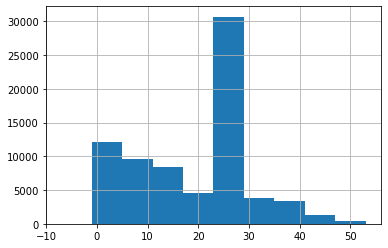

In [104]:
var = 'pump_age'

df_comp_val[var] = df_comp_val['year_recorded'] - df_comp_val['construction_year']

df_comp_val = df_comp_val.drop(labels=['year_recorded','date_recorded','construction_year'],axis=1)

df_comp_val[var].hist()

## Review missing data

In [105]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 74249
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     74250 non-null  int64   
 1   amount_tsh             74250 non-null  float64 
 2   gps_height             74250 non-null  int64   
 3   installer              74250 non-null  object  
 4   longitude              74250 non-null  float64 
 5   latitude               74250 non-null  float64 
 6   basin                  74250 non-null  object  
 7   region                 74250 non-null  object  
 8   district_code          74250 non-null  int64   
 9   population             74250 non-null  int64   
 10  public_meeting         74250 non-null  int32   
 11  permit                 74250 non-null  int32   
 12  extraction_type_class  74250 non-null  category
 13  management             74250 non-null  category
 14  payment_type           74250 non-null 

## Save final data

In [108]:
train_index = df_train_val.id.tolist()
test_index = df_test_val.id.tolist()

df_comp_val['status_group'] = df_train_lab['status_group']

df_comp_val.to_csv(data_interim_dir+'comp_data_clean_impv2_geo-corr.csv',index=False)